In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
import tensorflow as tf 
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

2025-08-16 23:19:34.716691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755386374.918896      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755386374.975844      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preprocessing

In [2]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'
seed = 42

In [3]:
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print('original class counts: ', class_counts)

original class counts:  {'surprise': 3171, 'fear': 4097, 'angry': 3995, 'neutral': 4965, 'sad': 4830, 'disgust': 436, 'happy': 7215}


In [4]:
import shutil
import math

output_dir = "/kaggle/working/fer_aug_dataset"
if not os.path.exists(output_dir):
    shutil.copytree(train_dir, output_dir)

max_count = 1200
target_classes = [ "sad", "angry", "surprise", "fear", "neutral","disgust"] 

aug_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32  # big speed boost

for class_name in target_classes:
    
    folder_path = os.path.join(output_dir, class_name)

    original_images = [f for f in os.listdir(folder_path) if not f.startswith("aug")]
    num_needed = max_count 
    print(f"Augmenting {class_name} by {num_needed} images")

    # Load all originals into memory
    X = []
    for img_name in original_images:
        arr = img_to_array(load_img(os.path.join(folder_path, img_name), color_mode="grayscale"))
        X.append(arr)
    X = np.array(X)

    # Repeat originals to fill augmentation need, but limit to 2 per original
    repeats = min(2, math.ceil(num_needed / len(original_images)))
    X = np.tile(X, (repeats, 1, 1, 1))  # repeat in memory

    # Shuffle so not all augmentations are from the same image
    np.random.shuffle(X)

    # Limit to exactly num_needed images
    X = X[:num_needed]
    flow = aug_gen.flow(
        X,
        batch_size=batch_size,
        save_to_dir=folder_path,
        save_prefix="aug",
        save_format="jpg"
    )

    steps = math.ceil(len(X) / batch_size)
    for _ in range(steps):
        next(flow)

print("Dataset created in:", output_dir)

Augmenting sad by 1200 images
Augmenting angry by 1200 images
Augmenting surprise by 1200 images
Augmenting fear by 1200 images
Augmenting neutral by 1200 images
Augmenting disgust by 1200 images
Dataset created in: /kaggle/working/fer_aug_dataset


In [5]:
aug_class_counts = {}
for class_name in os.listdir(output_dir):
    class_path = os.path.join(output_dir, class_name)
    if os.path.isdir(class_path):
        aug_class_counts[class_name] = len(os.listdir(class_path))

print('Augmented class counts: ', aug_class_counts)

Augmented class counts:  {'fear': 5297, 'sad': 6030, 'angry': 5195, 'disgust': 1308, 'neutral': 6165, 'surprise': 4371, 'happy': 7215}


data still unbalanced 

In [ ]:
## save the data and upload it as Kaggle dataset 
!zip -r augmented_data.zip /kaggle/working/fer_aug_dataset

In [3]:
def enhance(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img.astype(np.uint8))
    img = cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2RGB)
    img = img.astype(np.float32) 

    return img

In [4]:
aug_dir = '/kaggle/input/fer-augmented/FER_augmented'
img_size = (96, 96)

base_datagen = ImageDataGenerator(
    preprocessing_function=enhance,
    rescale = 1./255,
    validation_split = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = base_datagen.flow_from_directory(
    aug_dir,
    color_mode = 'rgb',
    target_size =  img_size,
    class_mode = 'categorical',
    subset="training",
    shuffle=True,
    seed=seed
)
val_generator = base_datagen.flow_from_directory(
    aug_dir,
    color_mode = 'rgb',
    target_size = img_size,
    class_mode = 'categorical',
    subset="validation",
    shuffle=True,
    seed=seed
)
test_datagen = ImageDataGenerator(
    preprocessing_function=enhance,
    rescale=1./255    
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode = 'rgb',
    target_size = img_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 28466 images belonging to 7 classes.
Found 7115 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


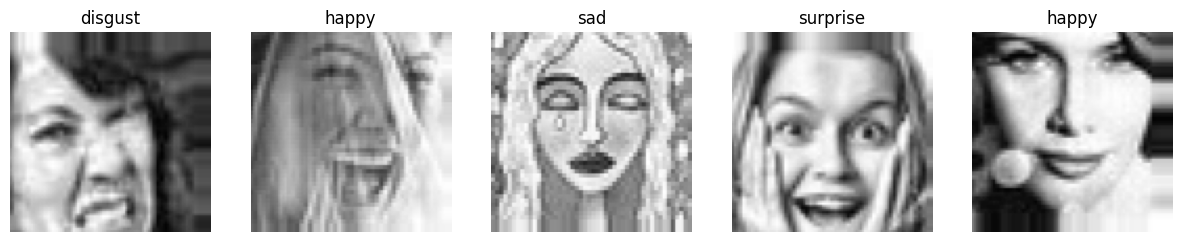

In [7]:
images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize = (15,5))

for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index])
    plt.axis('off')

plt.show()

# Define Models

## Custom 10 Layers CNN Model

In [5]:
cnn_model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu',input_shape = (96,96,3)),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),

    Conv2D(256, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.3),

    Conv2D(512, (3,3), padding='same', activation='relu'),
    Conv2D(512, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.3),


    Flatten(),
    Dense(512, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755386505.041297      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,105,319 (27.10 MB)

 Trainable params: 7,105,319 (27.10 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
cnn_model.compile(optimizer = Adam(learning_rate=1e-4),
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [7]:
early_stopping = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4)

save_model = ModelCheckpoint('cnn1_best_model.h5',
                             monitor='val_loss', save_best_only=True, verbose=1)

In [8]:
history1 = cnn_model.fit(train_generator, 
                          epochs=30,
                          validation_data=(val_generator),
                         callbacks=[early_stopping, save_model, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1755386562.067071     117 service.cc:148] XLA service 0x780c900066e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755386562.067589     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755386562.787189     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/890 ━━━━━━━━━━━━━━━━━━━━ 3:14:28 13s/step - accuracy: 0.1250 - loss: 1.9480

I0000 00:00:1755386569.270066     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1737 - loss: 1.8978
Epoch 1: val_loss improved from inf to 1.87763, saving model to cnn1_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 208s 219ms/step - accuracy: 0.1737 - loss: 1.8978 - val_accuracy: 0.2028 - val_loss: 1.8776 - learning_rate: 1.0000e-04
Epoch 2/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2365 - loss: 1.8170
Epoch 2: val_loss improved from 1.87763 to 1.62582, saving model to cnn1_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 146s 164ms/step - accuracy: 0.2366 - loss: 1.8169 - val_accuracy: 0.3689 - val_loss: 1.6258 - learning_rate: 1.0000e-04
Epoch 3/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3781 - loss: 1.5817
Epoch 3: val_loss improved from 1.62582 to 1.44260, saving model to cnn1_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 147s 165ms/step - accuracy: 0.3781 - loss: 1.5816 - val_accuracy: 0.4451 - val_loss: 1.4426 - learning_rate: 1.0000e-04
Epoch 4/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 

225/225 ━━━━━━━━━━━━━━━━━━━━ 47s 205ms/step


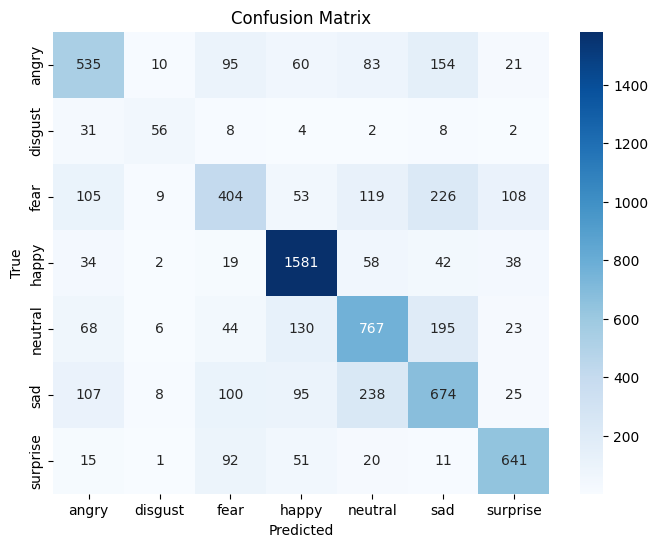

Classification Report:
               precision    recall  f1-score   support

       angry       0.60      0.56      0.58       958
     disgust       0.61      0.50      0.55       111
        fear       0.53      0.39      0.45      1024
       happy       0.80      0.89      0.84      1774
     neutral       0.60      0.62      0.61      1233
         sad       0.51      0.54      0.53      1247
    surprise       0.75      0.77      0.76       831

    accuracy                           0.65      7178
   macro avg       0.63      0.61      0.62      7178
weighted avg       0.64      0.65      0.64      7178



In [9]:
y_true = test_generator.classes  
class_labels = list(test_generator.class_indices.keys()) 

y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

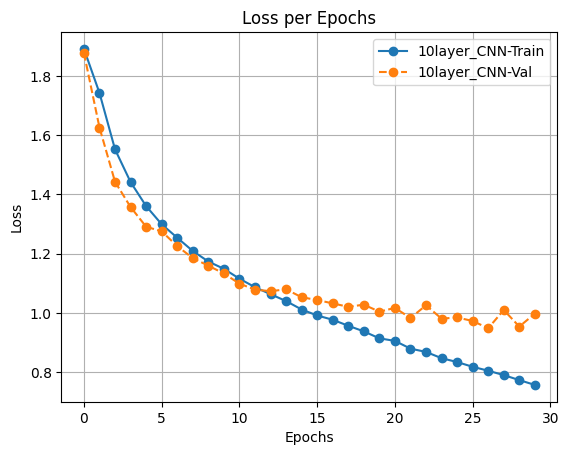

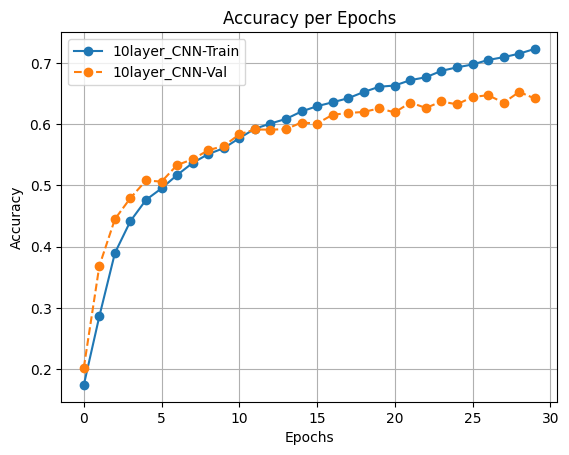

In [10]:
plt.plot(history1.history['loss'], label='10layer_CNN-Train', marker='o')
plt.plot(history1.history['val_loss'], label='10layer_CNN-Val',linestyle='--', marker='o')
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(history1.history['accuracy'], label='10layer_CNN-Train', marker='o')
plt.plot(history1.history['val_accuracy'], label='10layer_CNN-Val',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## Custom 12 layer CNN Model

In [16]:
cnn_model2 = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu',input_shape = (96,96,3)),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),

    Conv2D(256, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.3),

    Conv2D(512, (3,3), padding='same', activation='relu'),
    Conv2D(512, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.3),

    Conv2D(1024, (3,3), padding='same', activation='relu'),
    Conv2D(1024, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

cnn_model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 3, 3, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 3, 3, 1024)     │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             

 Total params: 19,428,135 (74.11 MB)

 Trainable params: 19,428,135 (74.11 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
cnn_model2.compile(optimizer = Adam(learning_rate=1e-4),
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4)

save_model = ModelCheckpoint('cnn2_best_model.h5',
                             monitor='val_loss', save_best_only=True, verbose=1)

In [18]:
history2 = cnn_model2.fit(train_generator, 
                          epochs=30,
                          validation_data=(val_generator),
                         callbacks=[early_stopping, save_model, reduce_lr])

Epoch 1/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1903 - loss: 1.8909
Epoch 1: val_loss improved from inf to 1.77706, saving model to cnn2_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 153s 161ms/step - accuracy: 0.1903 - loss: 1.8909 - val_accuracy: 0.2686 - val_loss: 1.7771 - learning_rate: 1.0000e-04
Epoch 2/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2950 - loss: 1.7396
Epoch 2: val_loss improved from 1.77706 to 1.57035, saving model to cnn2_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 131s 147ms/step - accuracy: 0.2951 - loss: 1.7395 - val_accuracy: 0.3851 - val_loss: 1.5703 - learning_rate: 1.0000e-04
Epoch 3/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3899 - loss: 1.5566
Epoch 3: val_loss improved from 1.57035 to 1.42732, saving model to cnn2_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 132s 148ms/step - accuracy: 0.3899 - loss: 1.5566 - val_accuracy: 0.4462 - val_loss: 1.4273 - learning_rate: 1.0000e-04
Epoch 4/30
890/890 ━━━━━━━━━━━━━

225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step


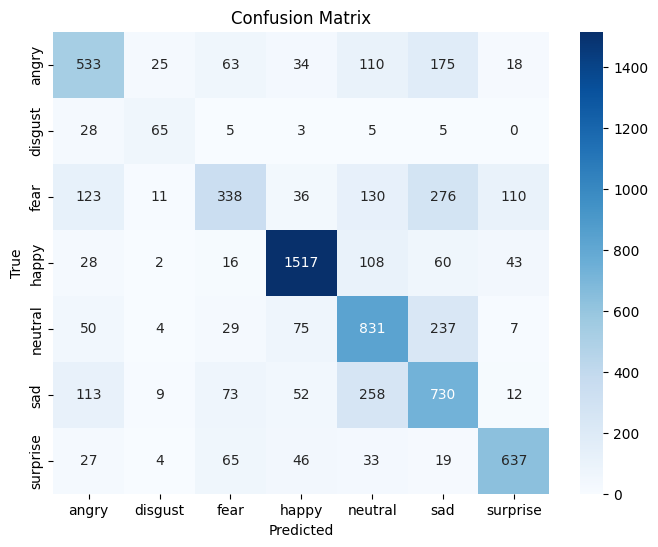

Classification Report:
               precision    recall  f1-score   support

       angry       0.59      0.56      0.57       958
     disgust       0.54      0.59      0.56       111
        fear       0.57      0.33      0.42      1024
       happy       0.86      0.86      0.86      1774
     neutral       0.56      0.67      0.61      1233
         sad       0.49      0.59      0.53      1247
    surprise       0.77      0.77      0.77       831

    accuracy                           0.65      7178
   macro avg       0.63      0.62      0.62      7178
weighted avg       0.65      0.65      0.64      7178



In [19]:
y_true = test_generator.classes  
class_labels = list(test_generator.class_indices.keys()) 

y_pred_probs = cnn_model2.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

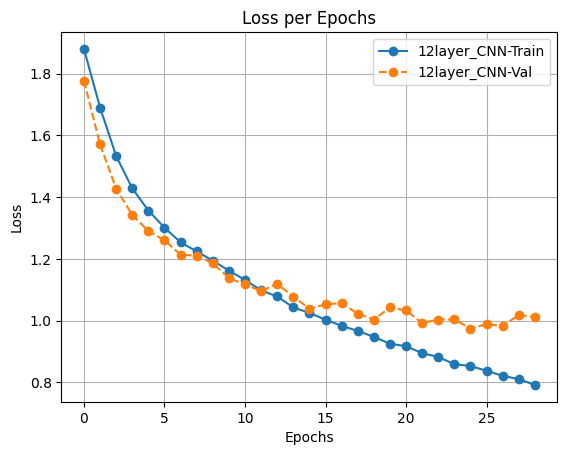

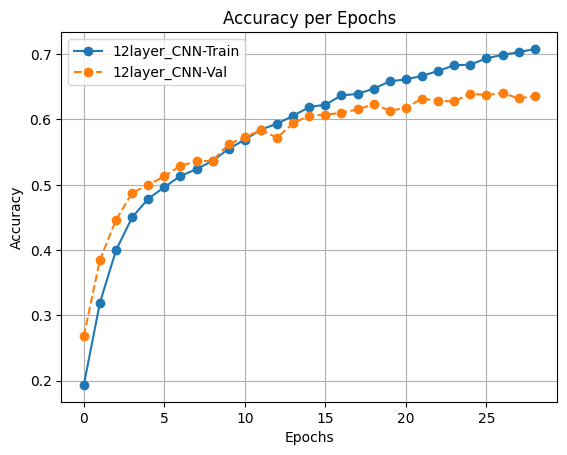

In [33]:
plt.plot(history2.history['loss'], label='12layer_CNN-Train', marker='o')
plt.plot(history2.history['val_loss'], label='12layer_CNN-Val',linestyle='--', marker='o')
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(history2.history['accuracy'], label='12layer_CNN-Train', marker='o')
plt.plot(history2.history['val_accuracy'], label='12layer_CNN-Val',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

the 6 Layers Model has the same result as the 5 Layers Model 

## Custom 16 Layer CNN Model

In [22]:
cnn_model3 = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu',input_shape = (96,96,3)),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.2),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.3),

    Conv2D(256, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.3),

    Conv2D(512, (3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Conv2D(512, (3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(1024, (3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Conv2D(1024, (3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    MaxPool2D((2,2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

cnn_model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,907,175 (79.75 MB)

 Trainable params: 20,905,319 (79.75 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [23]:
cnn_model3.compile(optimizer = Adam(learning_rate=1e-4),
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [24]:
early_stopping = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4)

save_model = ModelCheckpoint('cnn3_best_model.h5',
                             monitor='val_loss', save_best_only=True, verbose=1)

In [25]:
history3 = cnn_model3.fit(train_generator, 
                          epochs=30,
                          validation_data=(val_generator),
                         callbacks=[early_stopping, save_model, reduce_lr])

Epoch 1/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.2087 - loss: 11.1507
Epoch 1: val_loss improved from inf to 1.75214, saving model to cnn3_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 208s 211ms/step - accuracy: 0.2087 - loss: 11.1441 - val_accuracy: 0.2772 - val_loss: 1.7521 - learning_rate: 1.0000e-04
Epoch 2/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3180 - loss: 1.7110
Epoch 2: val_loss improved from 1.75214 to 1.72722, saving model to cnn3_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 150s 168ms/step - accuracy: 0.3180 - loss: 1.7110 - val_accuracy: 0.3129 - val_loss: 1.7272 - learning_rate: 1.0000e-04
Epoch 3/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3958 - loss: 1.5466
Epoch 3: val_loss did not improve from 1.72722
890/890 ━━━━━━━━━━━━━━━━━━━━ 146s 164ms/step - accuracy: 0.3958 - loss: 1.5465 - val_accuracy: 0.3089 - val_loss: 1.8653 - learning_rate: 1.0000e-04
Epoch 4/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.43

225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step


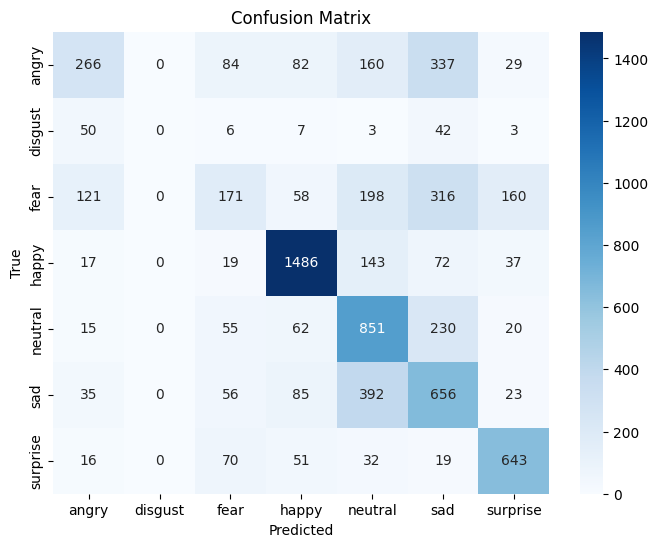

Classification Report:
               precision    recall  f1-score   support

       angry       0.51      0.28      0.36       958
     disgust       0.00      0.00      0.00       111
        fear       0.37      0.17      0.23      1024
       happy       0.81      0.84      0.82      1774
     neutral       0.48      0.69      0.57      1233
         sad       0.39      0.53      0.45      1247
    surprise       0.70      0.77      0.74       831

    accuracy                           0.57      7178
   macro avg       0.47      0.47      0.45      7178
weighted avg       0.55      0.57      0.55      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
y_true = test_generator.classes  
class_labels = list(test_generator.class_indices.keys()) 

y_pred_probs = cnn_model3.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

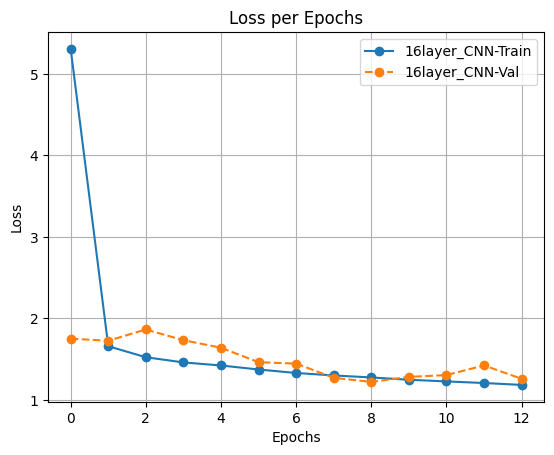

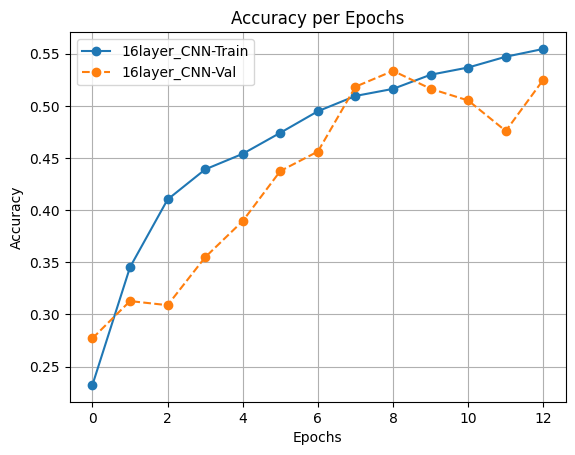

In [27]:
plt.plot(history3.history['loss'], label='16layer_CNN-Train', marker='o')
plt.plot(history3.history['val_loss'], label='16layer_CNN-Val',linestyle='--', marker='o')
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(history3.history['accuracy'], label='16layer_CNN-Train', marker='o')
plt.plot(history3.history['val_accuracy'], label='16layer_CNN-Val',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## MobileNetV2 Model

In [25]:
input_shape = (96,96,3)

base_model = MobileNetV2(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

for layer in base_model.layers:
    layer.trainabel = False

x1 = base_model.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(256, activation='relu')(x1)
x1 = Dropout(0.2)(x1)
output_layer = Dense(7, activation='softmax')(x1)

mobilenet_model = Model(
    inputs= base_model.input,
    outputs = output_layer
)

mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 2,553,607 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [26]:
mobilenet_model.compile(optimizer = Adam(learning_rate = 1e-4),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4)

save_model = ModelCheckpoint('mobilenet_best_model.h5',
                             monitor='val_loss', save_best_only=True, verbose=1)

In [28]:
mobilenet_history = mobilenet_model.fit(train_generator, epochs = 30,
                                        validation_data = (val_generator),
                                        callbacks=[early_stopping, save_model, reduce_lr])

Epoch 1/30


E0000 00:00:1755122879.178483     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755122879.361665     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755122879.625228     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755122879.829327     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


140/890 ━━━━━━━━━━━━━━━━━━━━ 1:29 120ms/step - accuracy: 0.2435 - loss: 1.9764

E0000 00:00:1755122913.967165     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755122914.152701     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755122914.417980     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755122914.622375     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3389 - loss: 1.7060
Epoch 1: val_loss improved from inf to 1.81086, saving model to mobilenet_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 211s 175ms/step - accuracy: 0.3390 - loss: 1.7058 - val_accuracy: 0.4008 - val_loss: 1.8109 - learning_rate: 1.0000e-04
Epoch 2/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5031 - loss: 1.2824
Epoch 2: val_loss improved from 1.81086 to 1.43927, saving model to mobilenet_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 133s 150ms/step - accuracy: 0.5031 - loss: 1.2823 - val_accuracy: 0.4814 - val_loss: 1.4393 - learning_rate: 1.0000e-04
Epoch 3/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5587 - loss: 1.1456
Epoch 3: val_loss improved from 1.43927 to 1.34559, saving model to mobilenet_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 131s 147ms/step - accuracy: 0.5587 - loss: 1.1456 - val_accuracy: 0.5179 - val_loss: 1.3456 - learning_rate: 1.0000e-04
Epoch 4/30
890/890 ━━━━━━━━━

225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step


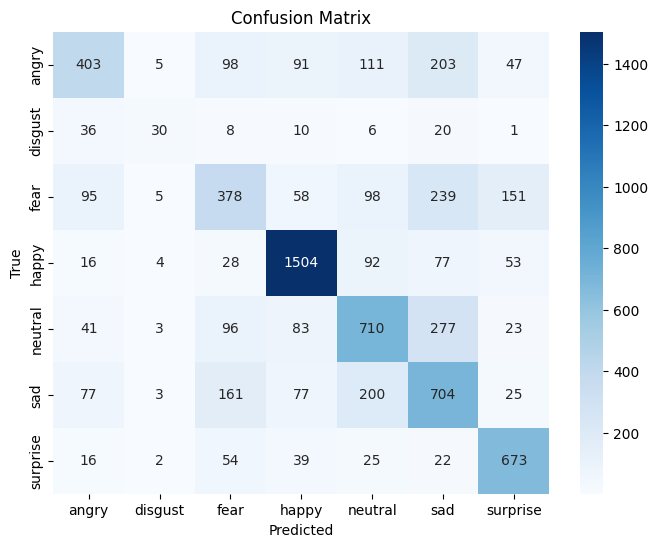

Classification Report:
               precision    recall  f1-score   support

       angry       0.59      0.42      0.49       958
     disgust       0.58      0.27      0.37       111
        fear       0.46      0.37      0.41      1024
       happy       0.81      0.85      0.83      1774
     neutral       0.57      0.58      0.57      1233
         sad       0.46      0.56      0.50      1247
    surprise       0.69      0.81      0.75       831

    accuracy                           0.61      7178
   macro avg       0.59      0.55      0.56      7178
weighted avg       0.61      0.61      0.61      7178



In [29]:
y_true = test_generator.classes  
class_labels = list(test_generator.class_indices.keys()) 

y_pred_probs = mobilenet_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

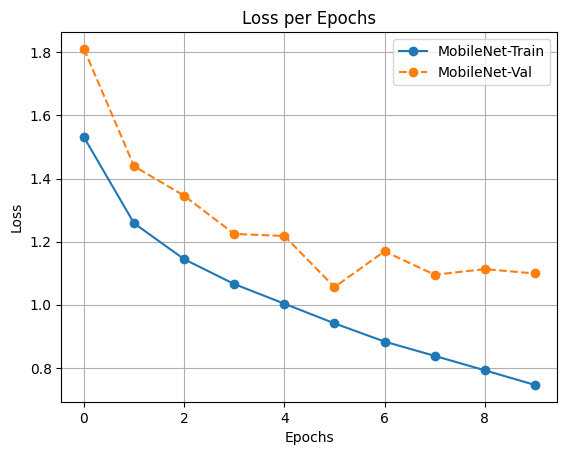

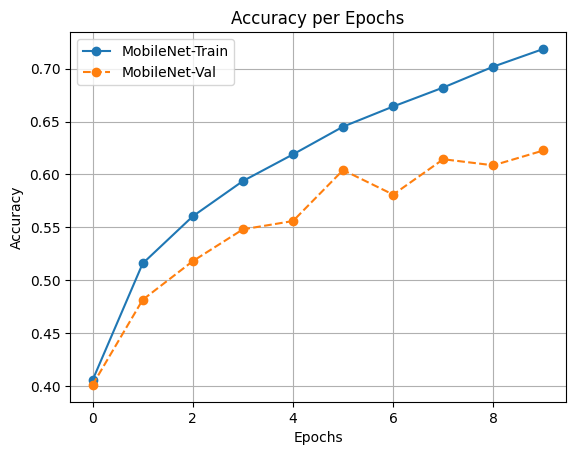

In [30]:
plt.plot(mobilenet_history.history['loss'], label='MobileNet-Train', marker='o')
plt.plot(mobilenet_history.history['val_loss'], label='MobileNet-Val',linestyle='--', marker='o')
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(mobilenet_history.history['accuracy'], label='MobileNet-Train', marker='o')
plt.plot(mobilenet_history.history['val_accuracy'], label='MobileNet-Val',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## MobileNetV2 Model with fine-tuning the last 30 layer

In [29]:
input_shape = (96,96,3)

base_model = MobileNetV2(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

for layer in base_model.layers[:30]:
    layer.trainabel = False
for layer in base_model.layers[30:]:
    layer.trainabel = True

x1 = base_model.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(256, activation='relu')(x1)
x1 = Dropout(0.2)(x1)
output_layer = Dense(7, activation='softmax')(x1)

mobilenet2_model = Model(
    inputs= base_model.input,
    outputs = output_layer
)

mobilenet2_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 2,553,607 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [30]:
mobilenet2_model.compile(optimizer = Adam(learning_rate = 1e-4),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [31]:
early_stopping = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4)

save_model = ModelCheckpoint('mobilenet2_best_model.h5',
                             monitor='val_loss', save_best_only=True, verbose=1)

In [32]:
mobilenet2_history = mobilenet2_model.fit(train_generator, epochs = 30,
                         validation_data = (val_generator),
                         callbacks=[early_stopping, save_model, reduce_lr])

Epoch 1/30


E0000 00:00:1755381642.013545     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755381642.196721     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755381642.462518     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755381642.667944     125 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


825/890 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.3389 - loss: 1.7240

E0000 00:00:1755381777.636650     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755381777.822602     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755381778.089973     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755381778.295783     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3443 - loss: 1.7099
Epoch 1: val_loss improved from inf to 1.76699, saving model to mobilenet2_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 237s 205ms/step - accuracy: 0.3444 - loss: 1.7097 - val_accuracy: 0.3907 - val_loss: 1.7670 - learning_rate: 1.0000e-04
Epoch 2/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5155 - loss: 1.2574
Epoch 2: val_loss improved from 1.76699 to 1.48492, saving model to mobilenet2_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 134s 151ms/step - accuracy: 0.5155 - loss: 1.2574 - val_accuracy: 0.4585 - val_loss: 1.4849 - learning_rate: 1.0000e-04
Epoch 3/30
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5580 - loss: 1.1522
Epoch 3: val_loss improved from 1.48492 to 1.25930, saving model to mobilenet2_best_model.h5
890/890 ━━━━━━━━━━━━━━━━━━━━ 134s 151ms/step - accuracy: 0.5580 - loss: 1.1521 - val_accuracy: 0.5282 - val_loss: 1.2593 - learning_rate: 1.0000e-04
Epoch 4/30
890/890 ━━━━━━

225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step


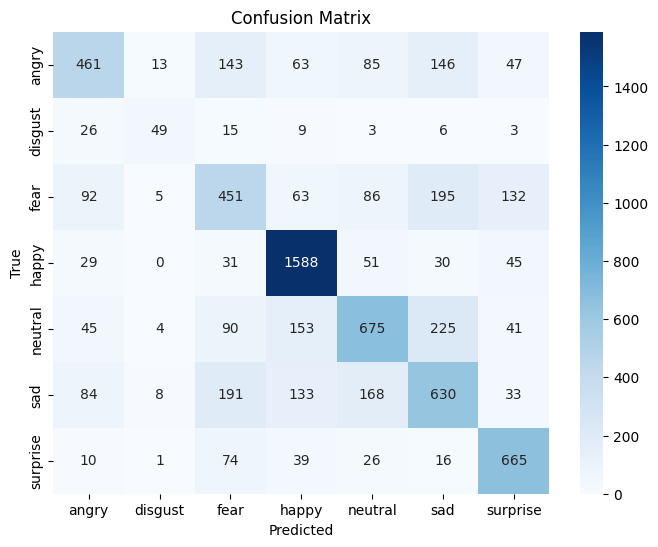

Classification Report:
               precision    recall  f1-score   support

       angry       0.62      0.48      0.54       958
     disgust       0.61      0.44      0.51       111
        fear       0.45      0.44      0.45      1024
       happy       0.78      0.90      0.83      1774
     neutral       0.62      0.55      0.58      1233
         sad       0.50      0.51      0.51      1247
    surprise       0.69      0.80      0.74       831

    accuracy                           0.63      7178
   macro avg       0.61      0.59      0.59      7178
weighted avg       0.62      0.63      0.62      7178



In [34]:
y_true = test_generator.classes  
class_labels = list(test_generator.class_indices.keys()) 

y_pred_probs = mobilenet2_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

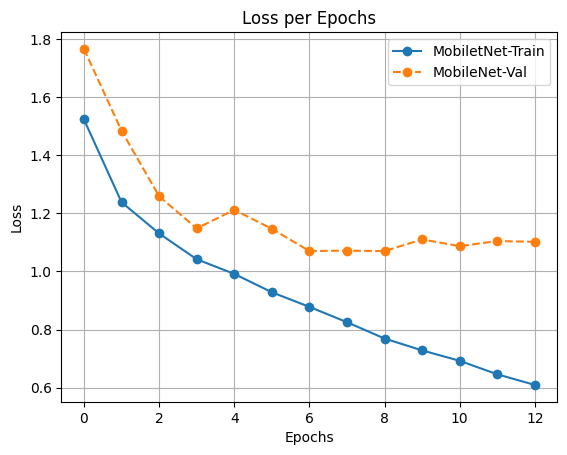

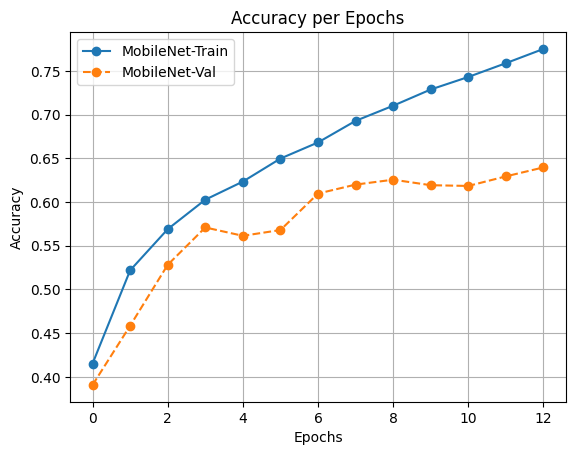

In [35]:
plt.plot(mobilenet2_history.history['loss'], label='MobiletNet-Train', marker='o')
plt.plot(mobilenet2_history.history['val_loss'], label='MobileNet-Val',linestyle='--', marker='o')
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(mobilenet2_history.history['accuracy'], label='MobileNet-Train', marker='o')
plt.plot(mobilenet2_history.history['val_accuracy'], label='MobileNet-Val',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Evaluating

### evaluating on the custom 10 Layers CNN Model as the best validation accuarcy and loss

### accuracy: 0.6897 - loss: 0.8438 - val_accuracy: 0.6398 - val_loss: 0.9746 - learning_rate: 1.0000e-04

In [41]:
loss, acc = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.5729 - loss: 1.0890
Test Accuracy: 64.64%
Test Loss: 0.9527


225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step


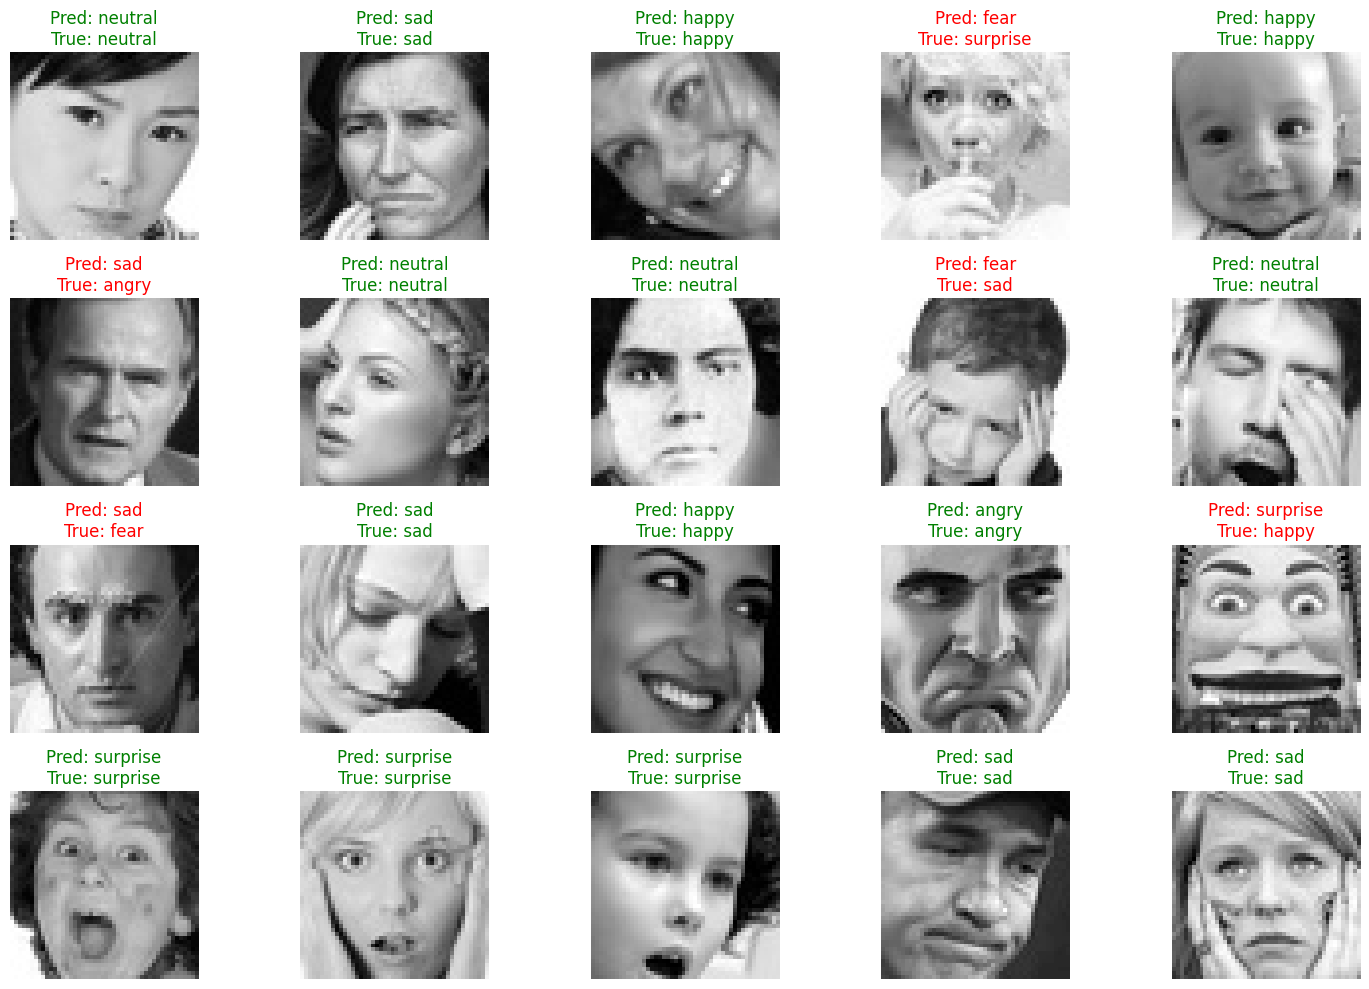

Correctly predicted: 15/20


In [46]:
predictions = cnn_model.predict(test_generator, verbose=1)
pred_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())
indices = np.random.choice(len(true_labels), 20, replace=False)

correct_count = 0
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    
    pred_label = pred_labels[idx]
    true_label = true_labels[idx]
    
    if pred_label == true_label:
        correct_count += 1

    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)

    plt.subplot(4, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", 
              color="green" if pred_label == true_label else "red")

plt.tight_layout()
plt.show()

print(f"Correctly predicted: {correct_count}/20")